# Lasso on the IBLI dataset

In this notebook, I will be using a Lasso Cross Validation model, and a Group Lasso model on the IBLI dataset

In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import os
import seaborn as sns
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone

# Load and preprocess the data

In [58]:
#Load in the dataset
df = pd.read_excel("C:/Users/daanm/Documents/Universiteit Utrecht/Scriptie/cattle_df.xlsx")
df.head(15)

,Unnamed: 0,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,eng_language,expend,...,main_info_source_recoded,religion_recoded,owns_phone,household_moved,purchase_bin,why_not_purchase_recoded,know_vip,trust_vip,advise_vip,ratio_insured_cattle
0,0,1,4,No,25,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes,0.0
1,1,2,4,Yes,27,Yes,No,Adult Education,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
2,2,3,4,Yes,29,No,No,Elementary,No,1,...,Professional and Organizational Sources,Christian,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
3,3,4,4,No,35,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
4,5,6,4,No,60,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,No,0.0
5,6,7,4,No,25,No,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,Yes,BOUGHT INSURANCE,Yes,Yes,Yes,0.0
6,7,8,4,No,61,Yes,No,Never attended,No,0,...,Interpersonal Sources,Christian,0,No,Yes,BOUGHT INSURANCE,Yes,Yes,Yes,0.0
7,8,9,4,No,45,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,No,0.0
8,9,10,4,No,30,Yes,No,Never attended,No,0,...,Professional and Organizational Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
9,11,12,4,No,30,No,No,Never attended,No,0,...,Interpersonal Sources,Christian,0,Yes,No,Lack of Awareness or Understanding,No,No,Yes,0.0


In [34]:
#Agreement has been made to drop the ratio column from this dataset since it introduces endogeneity

df = df.drop(['cs_cs_ratio_post_cattle','buy_nr_cattle','buy_cattle', 'ratio_insured_cattle', 'n_previd_cattle'], axis=1)
columns_list = df.columns.tolist()
print(columns_list)

['Unnamed: 0', 'id', 'wave', 'afm_language', 'age_constant', 'agric_land', 'amh_language', 'educ_recoded_constant', 'eng_language', 'expend', 'irrigated_land_bin', 'cs_cs_diff_post_cattle', 'number_minors', 'educ_child_recoded', 'activity_child_recoded', 'household_description', 'number_adults', 'main_info_source_recoded', 'religion_recoded', 'owns_phone', 'household_moved', 'purchase_bin', 'why_not_purchase_recoded', 'know_vip', 'trust_vip', 'advise_vip']


In [35]:
#Log+1 transforming the dataset to get a better distribution

df['cs_diff_log'] = np.log(np.abs(df['cs_cs_diff_post_cattle']) + 1)
df[['cs_cs_diff_post_cattle', 'cs_diff_log']].head()

,cs_cs_diff_post_cattle,cs_diff_log
0,-188.170624,5.242649
1,-850.367249,6.746844
2,-5219.686523,8.560384
3,-157.544266,5.066034
4,-158.881271,5.074431


# Deploying the Lasso Model
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [36]:
y = df['cs_diff_log']
X = df.drop(columns=['cs_diff_log', 'cs_cs_diff_post_cattle'])

In [37]:
categorical = X.select_dtypes(include=['object','category']).columns.tolist()
numerical = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [38]:
#Preprocess the pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical),
    
#Encode the categorical columns    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical)
])


In [39]:
#Create a Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'id', 'wave',
                                                   'age_constant', 'expend',
                                                   'irrigated_land_bin',
                                                   'number_minors',
                                                   'number_adults',
                                                   'owns_phone']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   One...ore'))]),
                                                  ['afm_language', 'agric_land',
                                                   'amh_language',
                                                   'educ_recoded_constant',
                                                   'eng_language',
                                                   'educ_child_recoded',
                                                   'activity_child_recoded',
                                                   'household_description',
                                                   'main_info_source_recoded',
                                                   'religion_recoded',
                                                   'household_moved',
                                                   'purchase_bin',
                                                   'why_not_purchase_recoded',
                                                   'know_vip', 'trust_vip',
                                                   'advise_vip'])])),
                ('lasso', LassoCV(cv=5, random_state=42))])

# Results

In [41]:
y_pred = lasso_pipeline.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R²: 0.11281579860960456
MSE: 2.4134202383170127


In [42]:
lasso_model = lasso_pipeline.named_steps['lasso']
coefficients = lasso_model.coef_
print("Number of non-zero coefficients:", np.sum(coefficients != 0))

Number of non-zero coefficients: 9


In [43]:
feature_names = lasso_pipeline.named_steps['preprocessor'].get_feature_names_out()

coef = lasso_pipeline.named_steps['lasso'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

#Remove the 0 coefficients
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

# Sort the coefficients
top_features = non_zero_coef_df.reindex(non_zero_coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(top_features.head(20))


                                       Feature  Coefficient
2                                    num__wave     0.529717
39  cat__religion_recoded_Traditional/Wakefata    -0.029404
7                           num__number_adults     0.026119
5                      num__irrigated_land_bin     0.021193
6                           num__number_minors     0.018775
8                              num__owns_phone     0.015750
1                                      num__id     0.003316
11                          cat__agric_land_No    -0.003264
3                            num__age_constant    -0.002669


# Grid search with Cross Validation

In [44]:
from sklearn.model_selection import GridSearchCV

#Define the new pipeline
lasso_pipeline_gs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(max_iter=10000))
])

#Define the grid
param_grid = {'lasso__alpha': [0.01,0.009,0.007,0.006,0.005]}

#Perform Grid Search

grid_search = GridSearchCV(lasso_pipeline_gs, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train,y_train)

print("Best alpha: ", grid_search.best_params_)
print("Best R²: ", grid_search.best_score_)

best_model = grid_search.best_estimator_



Best alpha:  {'lasso__alpha': 0.01}
Best R²:  0.09449501393335587


In [45]:
lasso_mae_list = []
lasso_rmse_list = []
lasso_mse_list = []

for alpha in param_grid['lasso__alpha']:
    model = Pipeline(steps=[
        ('preprocessor', clone(preprocessor)),
        ('lasso', Lasso(alpha=alpha, max_iter=10000))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)

    lasso_mae_list.append(mae)
    lasso_rmse_list.append(rmse)
    lasso_mse_list.append(mse)

In [46]:
y_pred = best_model.predict(X_test)
r2_test = r2_score(y_test,y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

print(f"Test R²: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")

Test R²: 0.1091
Test MAE: 1.0979


# Group Lasso
https://group-lasso.readthedocs.io/en/latest/index.html

For this Group Lasso, I will be grouping all of the dummy variables created by the encoding.

In [15]:
from group_lasso import GroupLasso

In [47]:
preprocessor_group = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical)
])
X_processed_group = preprocessor.fit_transform(X)

#Create the groups
group_list = []
group_id = 0

#create a group for each numerical value
for _ in numerical:
    group_list.append(group_id)
    group_id += 1

ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical)

#Create a group for each categorical value and dummy
grouped_counts = {}
for feature in cat_feature_names:
    prefix = feature.split("_")[0]
    grouped_counts[prefix] = grouped_counts.get(prefix,0) + 1

for _, count in grouped_counts.items():
    group_list.extend([group_id] * count)
    group_id += 1

groups = np.array(group_list)
print(groups)

[ 0  1  2  3  4  5  6  7  8  9  9 10 10 11 11 12 12 12 12 12 12 12 12 12
 13 13 14 14 14 14 14 15 15 15 15 15 16 16 16 17 17 17 18 18 19 19 19 19
 20 20 21 21 22 22]


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_group, y, test_size=0.2, random_state=42)

In [49]:
group_lasso = GroupLasso(groups=groups, group_reg=0.005, l1_reg=0.05,
                         scale_reg="group_size", supress_warning=True, n_iter=1000)

group_lasso.fit(X_train, y_train)

y_pred = group_lasso.predict(X_test)

print("R^2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Number of non-zero coefficients:", np.sum(group_lasso.coef_ != 0))

R^2: 0.10820076757911146
MSE: 2.4259745751413133
Number of non-zero coefficients: 1


In [50]:
feature_names = df.drop('cs_diff_log', axis=1).columns

non_zero_indices = np.where(group_lasso.coef_ != 0)[0]

non_zero_features = [(feature_names[i], group_lasso.coef_[i]) for i in non_zero_indices]

non_zero_df = pd.DataFrame(non_zero_features, columns=["Feature", "Coefficient"])
non_zero_df = non_zero_df.sort_values(by="Coefficient", key=abs, ascending=False)

print(non_zero_df)

  Feature          Coefficient
0    wave  [0.435610153337614]


# Grid search on Group Lasso

In [51]:
# Define the parameter grid

#Decides the penalty on groups
group_reg_values = [0.01, 0.05, 0.1,0.001 ,0.07] 

#Lasso penalty, decides penalty on individual features
l1_reg_values = [0.001, 0.005, 0.01, 0.05, 0.1]


best_score = -np.inf
best_params = None
results = []

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_processed_group, y, test_size=0.2, random_state=42)

In [53]:
# Manual grid search
for group_reg in group_reg_values:
    for l1_reg in l1_reg_values:
        model = GroupLasso(
            groups=groups,
            group_reg=group_reg,
            l1_reg=l1_reg,
            scale_reg="group_size",
            supress_warning=True,
            n_iter=1000
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = r2_score(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)

        results.append({
            'group_reg': group_reg,
            'l1_reg': l1_reg,
            'r2_score': score,
            'mse': mse,
            'rmse': rmse,
            'mae': mae
        })

        if score > best_score:
            best_score = score
            best_params = (group_reg, l1_reg)

In [54]:
print(f" Best R² Score: {best_score:.4f} with group_reg={best_params[0]}, l1_reg={best_params[1]}")

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="r2_score", ascending=False))

 Best R² Score: 0.1131 with group_reg=0.01, l1_reg=0.001
    group_reg  l1_reg  r2_score       mse      rmse       mae
0       0.010   0.001  0.113067  2.412738  1.553299  1.094756
17      0.001   0.010  0.112920  2.413136  1.553427  1.094849
1       0.010   0.005  0.112381  2.414604  1.553900  1.095817
2       0.010   0.010  0.111956  2.415759  1.554271  1.096906
16      0.001   0.005  0.110446  2.419866  1.555592  1.096535
18      0.001   0.050  0.108864  2.424172  1.556975  1.100115
5       0.050   0.001  0.108863  2.424172  1.556975  1.100115
6       0.050   0.005  0.108201  2.425974  1.557554  1.100686
3       0.010   0.050  0.107330  2.428342  1.558314  1.101371
7       0.050   0.010  0.107330  2.428342  1.558314  1.101371
20      0.070   0.001  0.105066  2.434503  1.560290  1.103437
21      0.070   0.005  0.104148  2.436998  1.561089  1.104307
22      0.070   0.010  0.102910  2.440366  1.562167  1.105513
15      0.001   0.001  0.102310  2.441998  1.562689  1.104072
8       0.050

Group Lasso does not seem to work as good? What groups did Sami use?

# Visualisations for comparison

In [55]:
lasso_results_df = pd.DataFrame(grid_search.cv_results_)
lasso_results_df = lasso_results_df[['param_lasso__alpha', 'mean_test_score']]
lasso_results_df.columns = ['l1_reg', 'r2_score']
lasso_results_df['mae'] = lasso_mae_list
lasso_results_df['mse'] = lasso_mse_list
lasso_results_df['rmse'] = lasso_rmse_list

group_lasso_results_df = pd.DataFrame(results)

lasso_results_df['model'] = 'Lasso'
group_lasso_results_df['model'] = 'Group Lasso'

combined_results = pd.concat([lasso_results_df, group_lasso_results_df], ignore_index=True)

In [56]:
combined_results_sorted = combined_results.sort_values(by='r2_score', ascending=False)

styled_table = combined_results_sorted.style\
    .background_gradient(subset=['r2_score'], cmap='Greens')\
    .format({'l1_reg': '{:.2e}', 'r2_score': '{:.4f}'})\
    .set_caption("Comparing Lasso and Group Lasso R² Scores")

styled_table


,l1_reg,r2_score,mae,mse,rmse,model,group_reg
5,1.00e-03,0.1131,1.094756,2.412738,1.553299,Group Lasso,0.010000
22,1.00e-02,0.1129,1.094849,2.413136,1.553427,Group Lasso,0.001000
6,5.00e-03,0.1124,1.095817,2.414604,1.553900,Group Lasso,0.010000
7,1.00e-02,0.1120,1.096906,2.415759,1.554271,Group Lasso,0.010000
21,5.00e-03,0.1104,1.096535,2.419866,1.555592,Group Lasso,0.001000
23,5.00e-02,0.1089,1.100115,2.424172,1.556975,Group Lasso,0.001000
10,1.00e-03,0.1089,1.100115,2.424172,1.556975,Group Lasso,0.050000
11,5.00e-03,0.1082,1.100686,2.425974,1.557554,Group Lasso,0.050000
8,5.00e-02,0.1073,1.101371,2.428342,1.558314,Group Lasso,0.010000
12,1.00e-02,0.1073,1.101371,2.428342,1.558314,Group Lasso,0.050000


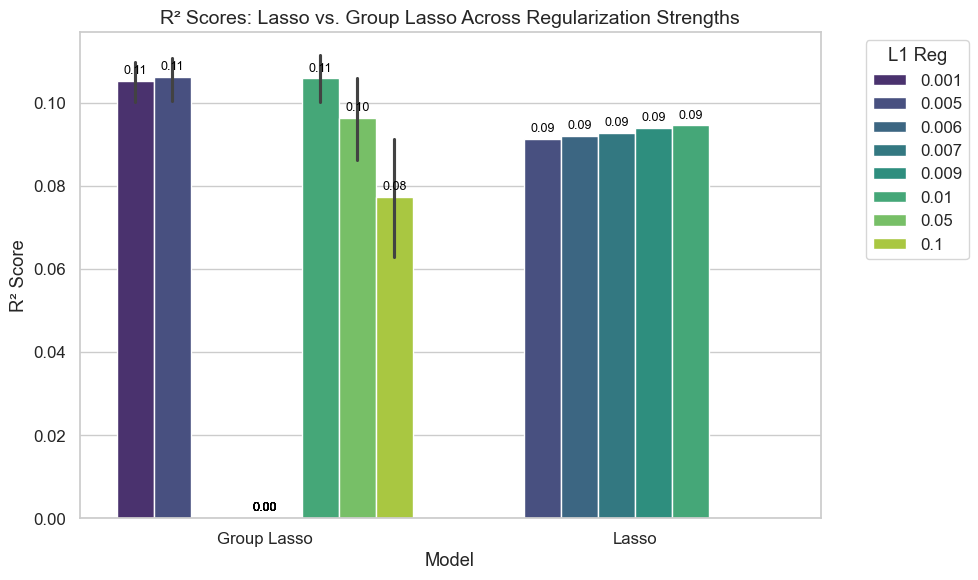

In [25]:
sns.set(style="whitegrid", font_scale=1.1)

combined_results = combined_results.sort_values(by='r2_score', ascending=False)

palette = sns.color_palette("viridis", as_cmap=False, n_colors=combined_results['l1_reg'].nunique())

# create the barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=combined_results,
    x='model',
    y='r2_score',
    hue='l1_reg',
    palette=palette,
    dodge=True
)

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                     textcoords='offset points')

plt.title('R² Scores: Lasso vs. Group Lasso Across Regularization Strengths', fontsize=14)
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.legend(title='L1 Reg', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()